In [1]:
import mxnet as mx
import numpy as np

import os, time, math, shutil, random

from mxnet import gluon, image, init, nd
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.model_zoo import vision as models

/home/ubuntu/anaconda3/lib/python3.6/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


In [2]:
def mkdir_if_not_exist(path):
    if not os.path.exists(os.path.join(*path)):
        os.makedirs(os.path.join(*path))

task = 'skirt_length_labels'
warmup_label_dir = 'data/web/Annotations/skirt_length_labels.csv'
base_label_dir = 'data/base/Annotations/label.csv'

random.seed(1024)

image_path = []

mkdir_if_not_exist(['data/train_valid'])

with open(warmup_label_dir, 'r') as f:
    lines = f.readlines()
    tokens = [l.rstrip().split(',') for l in lines]
    for path, _, label in tokens:
        image_path.append(('web/' + path, label))

with open(base_label_dir, 'r') as f:
    lines = f.readlines()
    tokens = [l.rstrip().split(',') for l in lines]
    for path, tk, label in tokens:
        if tk == task:
            image_path.append(('base/' + path, label))

mkdir_if_not_exist(['data/train_valid', task])
mkdir_if_not_exist(['data/train_valid', task, 'train'])
mkdir_if_not_exist(['data/train_valid', task, 'val'])
m = len(list(image_path[0][1]))
for mm in range(m):
    mkdir_if_not_exist(['data/train_valid', task, 'train', str(mm)])
    mkdir_if_not_exist(['data/train_valid', task, 'val', str(mm)])

n = len(image_path)
random.shuffle(image_path)
train_count = 0
for path, label in image_path:
    label_index = list(label).index('y')
    src_path = os.path.join('data/', path)
    if train_count < n * 0.9:
        shutil.copy(src_path,
                    os.path.join('data/train_valid', task, 'train', str(label_index)))
    else:
        shutil.copy(src_path,
                    os.path.join('data/train_valid', task, 'val', str(label_index)))
    train_count += 1

In [3]:
def calculate_ap(labels, outputs):
    cnt = 0
    ap = 0.
    for label, output in zip(labels, outputs):
        for lb, op in zip(label.asnumpy().astype(np.int),
                          output.asnumpy()):
            op_argsort = np.argsort(op)[::-1]
            lb_int = int(lb)
            ap += 1.0 / (1+list(op_argsort).index(lb_int))
            cnt += 1
    return ((ap, cnt))

def transform_train(data, label):
    im = data.astype('float32') / 255
    auglist = image.CreateAugmenter(data_shape=(3, 224, 224), resize=256,
                                    rand_crop=True, rand_mirror=True,
                                    mean = np.array([0.485, 0.456, 0.406]),
                                    std = np.array([0.229, 0.224, 0.225]))
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2,0,1))
    return (im, nd.array([label]).asscalar())

def transform_val(data, label):
    im = data.astype('float32') / 255
    auglist = image.CreateAugmenter(data_shape=(3, 224, 224), resize=256,
                                    mean = np.array([0.485, 0.456, 0.406]),
                                    std = np.array([0.229, 0.224, 0.225]))
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2,0,1))
    return (im, nd.array([label]).asscalar())
    
def validate(net, val_data, ctx):
    metric = mx.metric.Accuracy()
    L = gluon.loss.SoftmaxCrossEntropyLoss()
    AP = 0.
    AP_cnt = 0
    val_loss = 0
    for i, batch in enumerate(val_data):
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, 
                                          batch_axis=0, even_split=False)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, 
                                           batch_axis=0, even_split=False)
        outputs = [net(X) for X in data]
        metric.update(label, outputs)
        loss = [L(yhat, y) for yhat, y in zip(outputs, label)]
        val_loss += sum([l.mean().asscalar() for l in loss]) / len(loss)
        ap, cnt = calculate_ap(label, outputs)
        AP += ap
        AP_cnt += cnt
    _, val_acc = metric.get()
    return ((val_acc, AP / AP_cnt, val_loss / len(val_data)))

In [4]:
lr = 1e-3
momentum = 0.9
wd = 1e-4
epochs = 10
batch_size = 64

num_gpu = 4
ctx = [mx.gpu(i) for i in range(num_gpu)]

train_path = os.path.join('data/train_valid', task, 'train')
val_path = os.path.join('data/train_valid', task, 'val')

In [5]:
pretrained_net = models.resnet50_v2(pretrained=True)

finetune_net = models.resnet50_v2(classes=6)
model_name = 'resnet50_v2'
finetune_net.features = pretrained_net.features
finetune_net.output.initialize(init.Xavier(), ctx = ctx)
finetune_net.collect_params().reset_ctx(ctx)
finetune_net.hybridize()

In [6]:
train_data = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(train_path, transform=transform_train),
    batch_size=batch_size, shuffle=True, num_workers=32)

val_data = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(val_path, transform=transform_val),
    batch_size=batch_size, shuffle=False, num_workers=32)

# Define Trainer
trainer = gluon.Trainer(finetune_net.collect_params(),
                        'sgd', {
                            'learning_rate': lr, 'momentum': momentum,'wd': wd
                        })

# Define Metric and Loss
metric = mx.metric.Accuracy()
L = gluon.loss.SoftmaxCrossEntropyLoss()
num_batch = len(train_data)

In [7]:
for epoch in range(epochs):
    tic = time.time()
    train_loss = 0
    metric.reset()

    AP = 0.
    AP_cnt = 0

    for i, batch in enumerate(train_data):
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
        with ag.record():
            outputs = [finetune_net(X) for X in data]
            loss = [L(yhat, y) for yhat, y in zip(outputs, label)]
        for l in loss:
            l.backward()

        trainer.step(batch_size)
        train_loss += sum([l.mean().asscalar() for l in loss]) / len(loss)

        metric.update(label, outputs)
        ap, cnt = calculate_ap(label, outputs)
        AP += ap
        AP_cnt += cnt

    train_map = AP / AP_cnt
    _, train_acc = metric.get()
    train_loss /= num_batch

    val_acc, val_map, val_loss = validate(finetune_net, val_data, ctx)
    print('[Epoch %d] Train-acc: %.3f, mAP: %.3f, loss: %.3f | Val-acc: %.3f, mAP: %.3f, loss: %.3f | time: %.1f' %
         (epoch, train_acc, train_map, train_loss, val_acc, val_map, val_loss, time.time() - tic))

[Epoch 0] Train-acc: 0.605, mAP: 0.757, loss: 1.022 | Val-acc: 0.766, mAP: 0.868, loss: 0.623 | time: 51.3
[Epoch 1] Train-acc: 0.752, mAP: 0.857, loss: 0.658 | Val-acc: 0.804, mAP: 0.891, loss: 0.508 | time: 38.3
[Epoch 2] Train-acc: 0.799, mAP: 0.886, loss: 0.542 | Val-acc: 0.833, mAP: 0.907, loss: 0.461 | time: 38.5
[Epoch 3] Train-acc: 0.834, mAP: 0.907, loss: 0.457 | Val-acc: 0.843, mAP: 0.913, loss: 0.425 | time: 37.8
[Epoch 4] Train-acc: 0.863, mAP: 0.924, loss: 0.379 | Val-acc: 0.861, mAP: 0.922, loss: 0.410 | time: 37.4
[Epoch 5] Train-acc: 0.879, mAP: 0.933, loss: 0.337 | Val-acc: 0.874, mAP: 0.930, loss: 0.367 | time: 38.4
[Epoch 6] Train-acc: 0.899, mAP: 0.945, loss: 0.288 | Val-acc: 0.883, mAP: 0.935, loss: 0.351 | time: 38.7
[Epoch 7] Train-acc: 0.919, mAP: 0.956, loss: 0.239 | Val-acc: 0.890, mAP: 0.939, loss: 0.314 | time: 37.1
[Epoch 8] Train-acc: 0.933, mAP: 0.964, loss: 0.201 | Val-acc: 0.906, mAP: 0.948, loss: 0.304 | time: 37.6
[Epoch 9] Train-acc: 0.939, mAP: 0.96

In [8]:
import matplotlib.pyplot as plt

skirt_attr = ['Invisible', 'Short', 'Knee', 'Midi', 'Ankle', 'Floor']

def classify_skirt(path):
    img_path = os.path.join('data/rank', path)
    with open(img_path, 'rb') as f:
        img = image.imdecode(f.read())
    plt.imshow(img.asnumpy())
    print(img.shape)
    data, _ = transform_val(img, 0)
    data = data.expand_dims(axis=0)
    out = finetune_net(data.as_in_context(ctx[0]))
    out = nd.SoftmaxActivation(out)
    pred = int(nd.argmax(out, axis=1).asscalar())
    prob = out[0][pred].asscalar()
    attr_name = skirt_attr[pred]
    return('With prob=%f, %s'%(prob, attr_name))

with open('data/rank/Tests/question.csv', 'r') as f:
    lines = f.readlines()
tokens = [l.rstrip().split(',') for l in lines]

test_images = [t[0] for t in tokens if t[1] == task]

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


(512, 512, 3)


'With prob=0.987878, Midi'

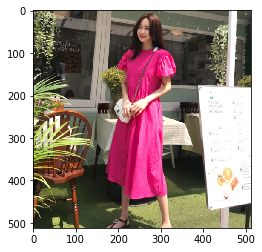

In [9]:
classify_skirt(test_images[0])

(768, 512, 3)


'With prob=0.936805, Floor'

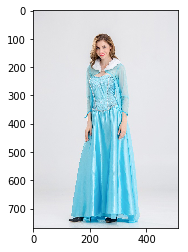

In [10]:
classify_skirt(test_images[2])

(512, 512, 3)


'With prob=0.988527, Short'

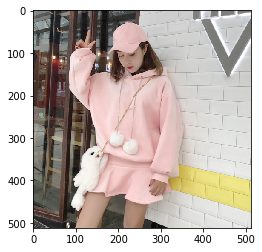

In [11]:
classify_skirt(test_images[3])

(315, 315, 3)


'With prob=0.999569, Ankle'

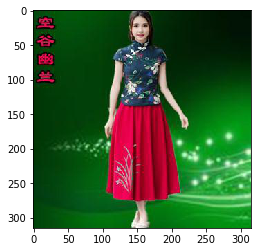

In [12]:
classify_skirt(test_images[5])

(512, 512, 3)


'With prob=0.963867, Knee'

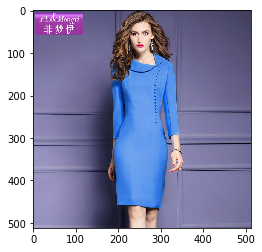

In [13]:
classify_skirt(test_images[1024])